# Data Driven Simulation

- Nama: Muhammad Habibulloh
- Email: habibmuhammadoct@gmail.com

In [10]:
!pip install simpy # simpy

In [11]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from simpy import Environment, Resource
import kagglehub
from datetime import datetime

## Step 1 Import Data Kaggle

### Dataset [Electric Vehicle Charging Patterns](https://www.kaggle.com/datasets/valakhorasani/electric-vehicle-charging-patterns)

In [12]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("valakhorasani/electric-vehicle-charging-patterns")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: /root/.cache/kagglehub/datasets/valakhorasani/electric-vehicle-charging-patterns/versions/1


In [15]:
import os

# List semua file dalam direktori dataset
print("Files in dataset directory:")
print(os.listdir(path))

Files in dataset directory:
['ev_charging_patterns.csv']


### Step 2 Load and Explore Datase

In [16]:
# Load dataset
df = pd.read_csv(f"{path}/ev_charging_patterns.csv")

In [17]:
print("\nDataset structure:")
print(df.head())


Dataset structure:
  User ID Vehicle Model  Battery Capacity (kWh) Charging Station ID  \
0  User_1        BMW i3              108.463007         Station_391   
1  User_2  Hyundai Kona              100.000000         Station_428   
2  User_3    Chevy Bolt               75.000000         Station_181   
3  User_4  Hyundai Kona               50.000000         Station_327   
4  User_5  Hyundai Kona               50.000000         Station_108   

  Charging Station Location  Charging Start Time    Charging End Time  \
0                   Houston  2024-01-01 00:00:00  2024-01-01 00:39:00   
1             San Francisco  2024-01-01 01:00:00  2024-01-01 03:01:00   
2             San Francisco  2024-01-01 02:00:00  2024-01-01 04:48:00   
3                   Houston  2024-01-01 03:00:00  2024-01-01 06:42:00   
4               Los Angeles  2024-01-01 04:00:00  2024-01-01 05:46:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346               

In [18]:
print("\nStatistics:")
print(df.describe())


Statistics:
       Battery Capacity (kWh)  Energy Consumed (kWh)  \
count             1320.000000            1254.000000   
mean                74.534692              42.642894   
std                 20.626914              22.411705   
min                  1.532807               0.045772   
25%                 62.000000              23.881193   
50%                 75.000000              42.691405   
75%                 85.000000              61.206218   
max                193.003074             152.238758   

       Charging Duration (hours)  Charging Rate (kW)  Charging Cost (USD)  \
count                1320.000000         1254.000000          1320.000000   
mean                    2.269377           25.963003            22.551352   
std                     1.061037           14.011326            10.751494   
min                     0.095314            1.472549             0.234317   
25%                     1.397623           13.856583            13.368141   
50%                 

**Insight**

- Kapasitas Baterai Rata-rata 74.5 kWh, maksimum 193 kWh
- Energi yang Dikonsumsi Rata-rata 42.6 kWh per sesi
- Durasi Pengisian Rata-rata 2.2 jam, maksimum 7.6 jam
- Laju Pengisian Rata-rata 25.9 kW
- Biaya Pengisian Rata-rata $22.5, maksimum 22.5, maksimum 69.4
- Status Pengisian Awal Rata-rata 49.1%
- Status Pengisian Akhir Rata-rata 75.1%
- Jarak Tempuh Rata-rata 153.6 km sejak pengisian terakhir
- Temperatur Rata-rata 15.3°C

In [19]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
User ID                                      0
Vehicle Model                                0
Battery Capacity (kWh)                       0
Charging Station ID                          0
Charging Station Location                    0
Charging Start Time                          0
Charging End Time                            0
Energy Consumed (kWh)                       66
Charging Duration (hours)                    0
Charging Rate (kW)                          66
Charging Cost (USD)                          0
Time of Day                                  0
Day of Week                                  0
State of Charge (Start %)                    0
State of Charge (End %)                      0
Distance Driven (since last charge) (km)    66
Temperature (°C)                             0
Vehicle Age (years)                          0
Charger Type                                 0
User Type                                    0
dtype: int64


In [20]:
# Convert time columns to datetime
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'])
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'])

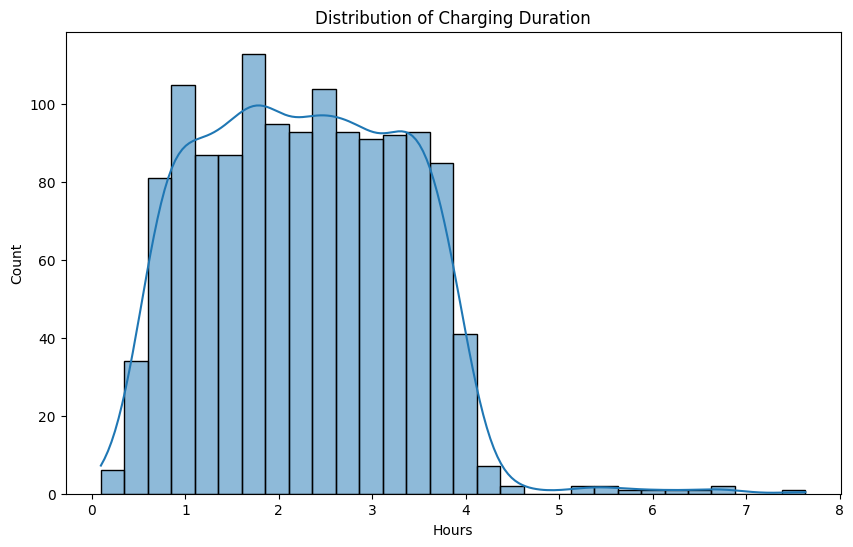

In [21]:
# Charging duration distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Charging Duration (hours)'], bins=30, kde=True)
plt.title('Distribution of Charging Duration')
plt.xlabel('Hours')
plt.show()

### Step 3 Implement the Queueing Simulation

In [22]:
# Sort by station and start time
df_sorted = df.sort_values(by=['Charging Station ID', 'Charging Start Time'])

# Calculate inter-arrival times per station
df_sorted['inter_arrival'] = df_sorted.groupby('Charging Station ID')['Charging Start Time'].diff().dt.total_seconds()/3600

# Filter relevant features
service_times = df_sorted['Charging Duration (hours)'].values
inter_arrivals = df_sorted['inter_arrival'].dropna().values

# Simulation parameters
NUM_STATIONS = len(df['Charging Station ID'].unique())
SIM_TIME = 168  # Simulate for 1 week (168 hours)

class ChargingStation:
    def __init__(self, env, num_chargers):
        self.env = env
        self.charger = Resource(env, capacity=num_chargers)

    def charge(self, duration):
        yield self.env.timeout(duration)

def user(env, name, station, duration):
    with station.charger.request() as request:
        yield request
        yield env.process(station.charge(duration))

def setup(env, num_chargers, inter_arrivals, service_times):
    station = ChargingStation(env, num_chargers)

    for i in range(len(inter_arrivals)):
        env.process(user(env, f'User_{i}', station, service_times[i]))
        yield env.timeout(inter_arrivals[i])

# Initialize simulation
env = Environment()
env.process(setup(env, NUM_STATIONS, inter_arrivals, service_times))
env.run(until=SIM_TIME)

### Step 4 Performance Analysis and Visualization


Performance Metrics:
Average Service Time: 2.27 hours
System Utilization: 3.86%


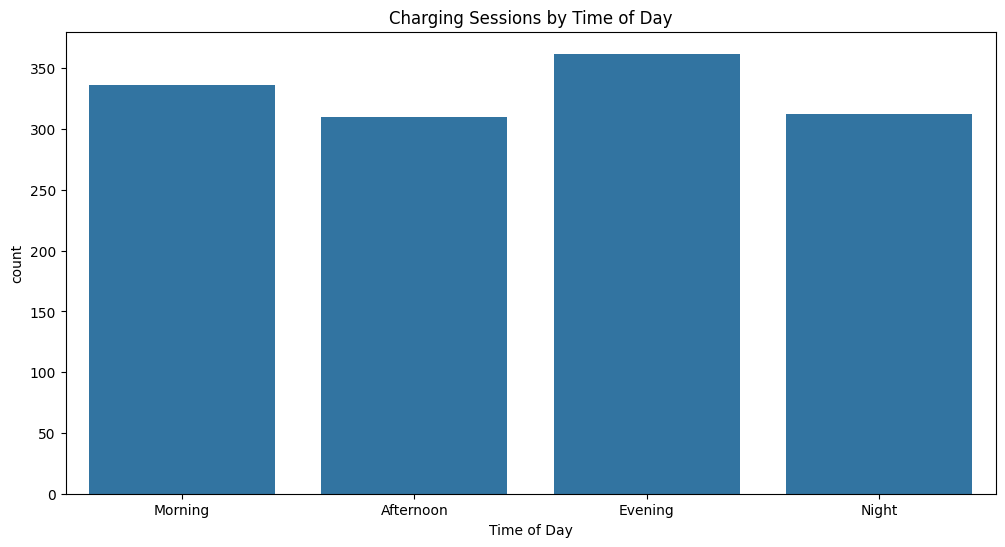

In [23]:
avg_service_time = np.mean(service_times)
utilization = (sum(service_times) / (NUM_STATIONS * SIM_TIME))

print(f"\nPerformance Metrics:")
print(f"Average Service Time: {avg_service_time:.2f} hours")
print(f"System Utilization: {utilization:.2%}")

# Visualization charging patterns by time of day
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='Time of Day', order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Charging Sessions by Time of Day')
plt.show()

### Step 5 Modify Parameters and Optimize

#### Contoh: Station Electric Charger ditambah 5

In [24]:
NEW_CHARGERS = NUM_STATIONS + 5

# Simulation with new parameters
env = Environment()
env.process(setup(env, NEW_CHARGERS, inter_arrivals, service_times))
env.run(until=SIM_TIME)

# Calculate new utilization
new_utilization = (sum(service_times) / (NEW_CHARGERS * SIM_TIME))
print(f"\nOptimized Utilization: {new_utilization:.2%}")


Optimized Utilization: 3.82%


### Insights

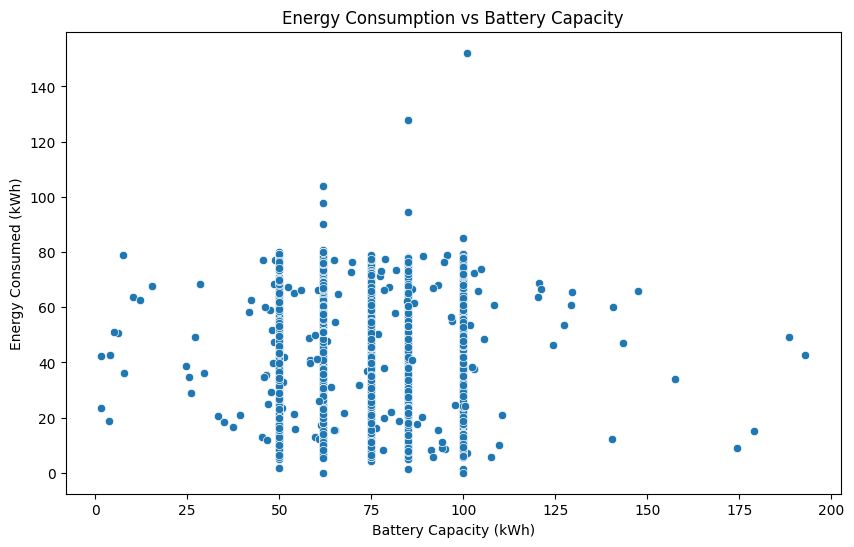

In [25]:
# Energy consumption vs battery capacity
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Battery Capacity (kWh)', y='Energy Consumed (kWh)')
plt.title('Energy Consumption vs Battery Capacity')
plt.show()

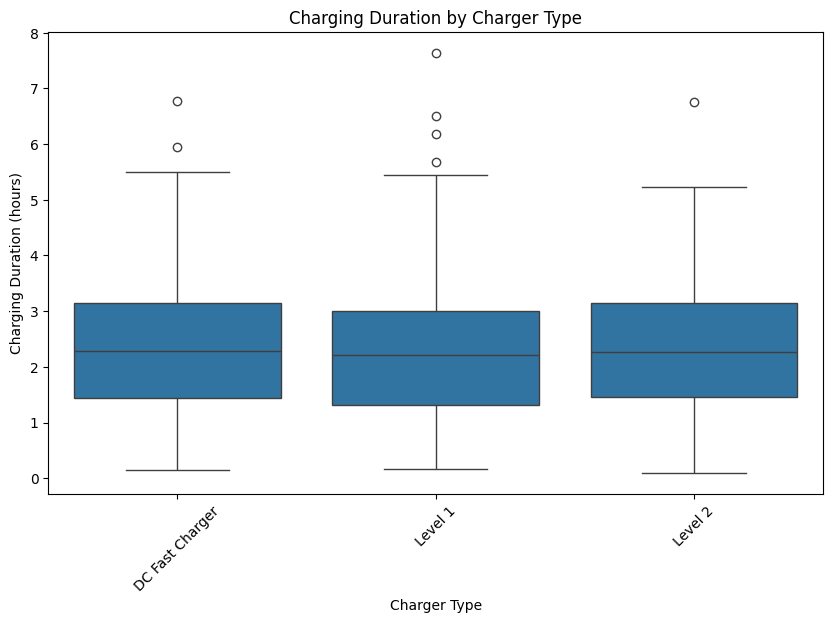

In [26]:
# Charging duration by charger type
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Charger Type', y='Charging Duration (hours)')
plt.title('Charging Duration by Charger Type')
plt.xticks(rotation=45)
plt.show()

### Final Report

In [27]:
report = f"""
Simulation Report
=================
- Total charging sessions simulated: {len(df)}
- Stations analyzed: {NUM_STATIONS}
- Average charging duration: {avg_service_time:.2f} hours
- Peak charging time: {df['Time of Day'].mode()[0]}
- Most common vehicle: {df['Vehicle Model'].mode()[0]}
- Optimization impact: Utilization reduced from {utilization:.2%} to {new_utilization:.2%}
"""

print(report)


Simulation Report
- Total charging sessions simulated: 1320
- Stations analyzed: 462
- Average charging duration: 2.27 hours
- Peak charging time: Evening
- Most common vehicle: Tesla Model 3
- Optimization impact: Utilization reduced from 3.86% to 3.82%

